# Self-Driving Car Engineer Nanodegree


## Project 5: Vehicle Detection and Tracking


---
## Step 0: Import Libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time

---

## Step 1: User Variables


In [25]:
ENABLE_CAMERA_CALIBRATION = True #enable the camera calibration process

----

## Step 2: Functions definition


### 1) Color and HOG functions

In [50]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_Color_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_HOG_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        if np.max(image)>1:
            image = image.astype(np.float32)/255
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        if np.max(feature_image)>1:
            print("DANIELA")
            image = image.astype(np.float32)/255
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
        
    
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


### 2) Sliding window functions

In [51]:
# Here is your draw_boxes function
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

### 3) Find cars functions

In [52]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

### 4) Dealing with false positives ans multiple windows functions

In [53]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


----

## Step 3: Train the SVM 


### 1) Overview of the sample images

We can verify that the amount of images is equilibrate, once the total of vehicles images is very close to the the total of images of non-vehicle images. Therefore, it is reasonable to use all these images for training and test the SVM.

In [54]:
#Count the number of elements in the folder
import os

def count_num_files (path,enable_print = True):
    #List all the directories inside the folder in path
    list = os.listdir(path)
    #Verify in each inner folder
    num_elements_=[]
    dir_folder_ = []
    total_elements  = 0
    for folder_name in list:
        if folder_name[0] != '.':
            dir_folder = path + folder_name
            num_elements = len(os.listdir(dir_folder))
            num_elements_.append(num_elements)
            dir_folder_.append(dir_folder)
            total_elements += num_elements
            if enable_print ==True:
                print (folder_name,": ",str(num_elements),'elements')
    if enable_print == True:
        print("TOTAL: ",str(total_elements ),"elements")
    return num_elements_,dir_folder_


print("VEHICLE IMAGES:")
path_vehicles= "./train_images/vehicles/"
path_non_vehicles= "./train_images/non-vehicles/"
num_vehicles,dir_vehicles = count_num_files(path_vehicles);
print("\r\nNON-VEHICLE IMAGES:")
num_non_vehicles,dir_non_vehicles = count_num_files(path_non_vehicles);



VEHICLE IMAGES:
GTI_Far :  835 elements
GTI_Left :  910 elements
GTI_MiddleClose :  420 elements
GTI_Right :  665 elements
KITTI_extracted :  5967 elements
TOTAL:  8797 elements

NON-VEHICLE IMAGES:
Extras :  5069 elements
GTI :  3901 elements
TOTAL:  8970 elements



### 2) Training the SVM

In [ ]:
#--------------------
#1) IMPORT THE IMAGES
#--------------------

#Vehicle images
cars = []
for dir in dir_vehicles:
    images = glob.glob(dir+"/*.png")
    for image in images:
        cars.append(image)

#Non-vehicle images
notcars = []
for dir in dir_non_vehicles:
    images = glob.glob(dir+"/*.png")
    for image in images:
        notcars.append(image)

print("Number of vehicle images:",len(cars))
print("Number of non-vehicle images:",len(notcars))

#-----------------------
#2) EXTRACT THE FEATURES
#-----------------------
#Parameters
color_space='RGB'
spatial_size=(64, 64)
hist_bins=32
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel="ALL"
spatial_feat=True
hist_feat=True
hog_feat=True
MAX_NUM_SAMPLES =len(cars)

#For img in cars:
count = 0
car_features = []
for directory in cars:
    img = mpimg.imread(directory)
    if np.max(img)>1:
        img = image_sample.astype(np.float32)/255
    features = single_img_features(img, color_space, spatial_size,
                            hist_bins, orient, 
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_feat, hist_feat, hog_feat)
    car_features.append(features)
    if count==MAX_NUM_SAMPLES:
        break
    count+=1

#car_features = np.ravel(car_features)

#For img in non cars:
count = 0
notcar_features = []
for directory in notcars:
    img = mpimg.imread(directory)
    if np.max(img)>1:
        img = img.astype(np.float32)/255
    features = single_img_features(img, color_space, spatial_size,
                            hist_bins, orient, 
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_feat, hist_feat, hog_feat)
    notcar_features.append(features)
    if count==MAX_NUM_SAMPLES:
        break
    count+=1

#notcar_features = np.ravel(notcar_features)
print("Number of Vehicle features:",str(len(car_features)))
print("Number of non-Vehicle features:",str(len(notcar_features)))

#----------------
#2) TRAIN THE SVM
#----------------

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)


# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Number of vehicle images: 8792
Number of non-vehicle images: 8968
Number of Vehicle features: 8792
Number of non-Vehicle features: 8793


----

## Step 4: Test the algorithm in sample images

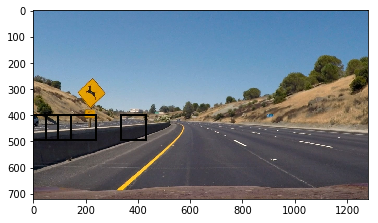

In [85]:
dir_test_img = "./test_images/test2.jpg"
y_start_stop = [400, 700] # Min and max in y to search in slide_window()
image_sample = mpimg.imread(dir_test_img)
if np.max(image_sample)>1:
    image_sample = image_sample.astype(np.float32)/255

plt.imshow(image_sample)

draw_image = np.copy(image_sample)
windows = slide_window(image_sample, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))


hot_windows = search_windows(image_sample, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       


window_img = draw_boxes(draw_image, hot_windows, color=(255, 255, 0), thick=6)                    

plt.imshow(window_img)



In [61]:
#Read the frames of the video
VideoPath = './project_video.mp4'
video = cv2.VideoCapture(VideoPath)

ret, frame =video.read()
#MOSTRAR RESUMO DO VIDEO
print("===========================================================")
print("Frame Shape:",frame.shape)
TotalFrames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print("Total de frames:",TotalFrames)
print("FPS: ",int(video.get(cv2.CAP_PROP_FPS)))
print("===========================================================")


#name of the output video
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video_out =cv2.VideoWriter('result4.mp4',fourcc,video.get(cv2.CAP_PROP_FPS), (frame.shape[1],frame.shape[0]))

#Define thresholds max and min for binary image construction
thresh_min = 45
thresh_max = 100
s_thresh_min = 170
s_thresh_max = 255

# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
countFrames = 0 
ENABLE_PLOT = False

while(ret == True):
    
    
    #Undistort the image
    undist = cal_undistort(frame,objpoints,imgpoints)
    
    #Creating binary image
    color_binary,combined_binary =CreateBinaryImage(undist,thresh_min,thresh_max,s_thresh_min,s_thresh_max)
    
    #warp the image
    warped = warp(combined_binary,src,dst)
   
    #warp the image original
    warped_original = warp(frame,src,dst)
    
    #find lane lines
    left_fit, right_fit,left_fit_cr,right_fit_cr,out_img,leftx_base,rightx_base = findLaneLines (warped ,nwindows,margin,minpix,ym_per_pix,xm_per_pix)

    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    
    #fill the road detection
    filled_img,window_img = fillRoad(warped_original,left_fitx,right_fitx,ploty)
    
    
    
    #Unwarp the image
    frame_out = frame.copy()
    unwarped = unwarp(window_img,src,dst)
    frame_out[unwarped.nonzero()] +=100
    
    #calulate the radius
    left_curverad, right_curverad = calculateRadius(warped,left_fit,right_fit,ym_per_pix)
    
    #calculate the position
    position = calculatePositions(leftx_base,rightx_base,out_img.shape,xm_per_pix)
    
    if position<0:
        pos = "left"
    else:
        pos = "right"
    position = np.absolute(position)
    #write the radius on the frame
    cv2.putText(frame_out,str("Radius of curvature: ")+str(round(left_curverad,2))+str("m"),(100,100), cv2.FONT_HERSHEY_DUPLEX,1.5, (255, 0, 0))
    cv2.putText(frame_out,str("Vehicle is ") + str(round(position,2))+str("m to the ")+ pos+str(" of center"),(100,200), cv2.FONT_HERSHEY_DUPLEX,1.5, (255, 0, 0))
    video_out.write(frame_out)

    countFrames = countFrames +1
    print(str(countFrames),"/",str(TotalFrames))
    
    
    if ENABLE_PLOT == True:
        
        #Original image
        plt.figure()
        plt.imshow(frame)
        
        #Undistorted image
        plt.figure()
        plt.imshow( undist)
        
        #Binary image
        plt.figure()
        plt.imshow( combined_binary)
        
        #Warp binary image
        plt.figure()
        plt.imshow( warped)
        
        #Warp original image
        plt.figure()
        plt.imshow( warped_original)
        
        #Lane Line detection
        plt.figure()
        plt.imshow(out_img)
        
        #Road detection
        plt.figure()
        plt.imshow(filled_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        
        #Undistort image
        plt.figure()
        plt.imshow(unwarped)
        
        #Undistort image
        plt.figure()
        plt.imshow(frame_out)
        
        #limit the quantity of images to be ploted
        if (countFrames >0):
            break
            
    #read next frame
    ret, frame =video.read()
    
    
#Save the video
video_out.release() 
video.release()


Frame Shape: (720, 1280, 3)
Total de frames: 1260
FPS:  25


NameError: name 'cal_undistort' is not defined

In [ ]:
#Unwarp the image
unwarped = unwarp(window_img,src,dst)

#Undistort image
plt.figure()
plt.imshow(unwarped)
frame2 = frame.copy()
frame2[unwarped.nonzero()] +=100
print(frame[unwarped.nonzero()].shape)
plt.figure()
#cv2.putText(frame2,str(left_curverad),(int(frame_out.shape[1]*0.65),int(frame_out.shape[0]*0.1)), cv2.FONT_HERSHEY_DUPLEX,1000, (255, 0, 0))


plt.imshow(frame2)

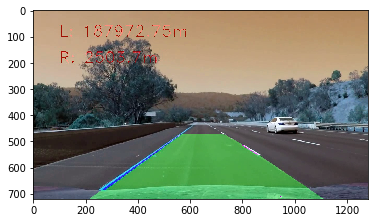

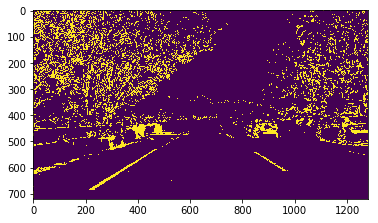

In [39]:
VideoPath = '../result3.mp4'
video = cv2.VideoCapture(VideoPath)


Numframe = 500
video.set(cv2.CAP_PROP_POS_FRAMES,Numframe)
ret, frame =video.read()
#Define thresholds max and min for binary image construction
l_thresh_min = 0
l_thresh_max = 255
thresh_min = 45
thresh_max = 100
s_thresh_min = 170
s_thresh_max = 255
#Creating binary image
color_binary,combined_binary =CreateBinaryImage(img,thresh_min,thresh_max,s_thresh_min,s_thresh_max)
plt.figure()
plt.imshow(frame)
plt.figure()
plt.imshow(combined_binary)


In [35]:
combined_binary.shape

(720, 1280)

In [36]:
720/2


360.0

In [37]:
1280/2-400

240.0